In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import re
import time
import string
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from transformers import (
    BertTokenizer, TFBertForSequenceClassification, pipeline
)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


# Data Preprocessing

Load data

In [2]:
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data = data.drop_duplicates('text')
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data.shape

(1581466, 6)

In [4]:
data.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [5]:
data['target'].unique()

array([0, 4])

In [6]:
# Map the target values to positive, negative, and neutral labels
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['target'])
# Select the relevant columns
df = data[['text', 'sentiment']]

## Sentiment Distribution Visualization

Visualize the distribution of sentiments

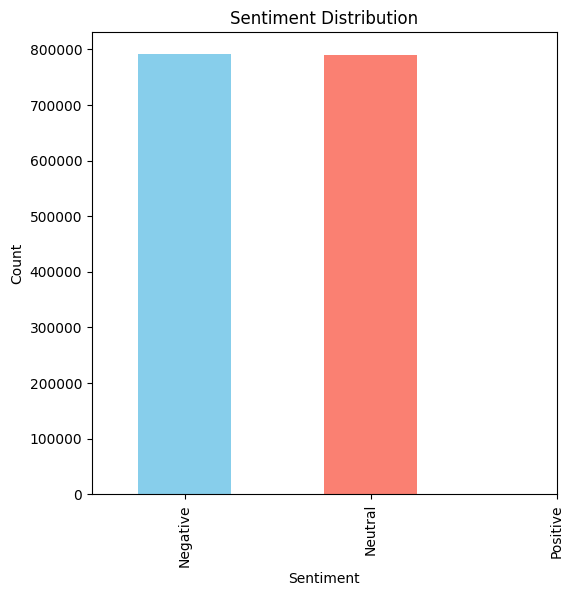

In [7]:
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

# Text Preprocessing

In [8]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function for text cleaning and tokenization
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove user handles and hashtags
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Join the words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
%%time
# Preprocess texts
df.text = df.text.map(lambda x: preprocess_text(x))
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 7min 13s, sys: 258 ms, total: 7min 13s
Wall time: 7min 13s


Play with wordclouds a little

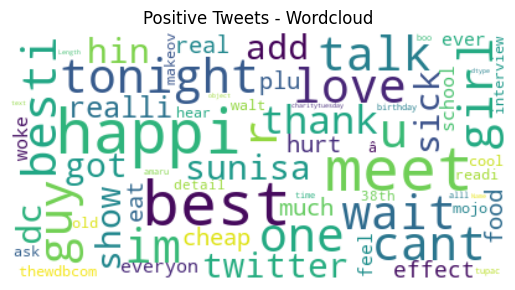

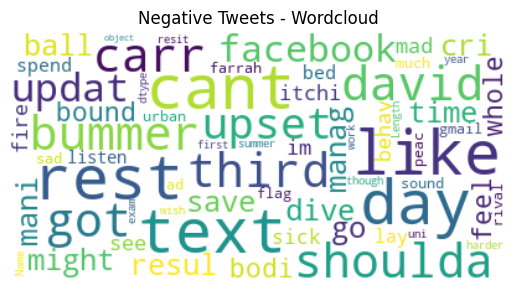

In [10]:
# Wordcloud with positive tweets
positive_tweets = df['text'][df["sentiment"] == 1]
stop_words = ["https", "co", "RT"] + STOPWORDS
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
# Wordcloud with negative tweets
negative_tweets = df['text'][df["sentiment"] == 0]
stop_words = ["https", "co", "RT"] + STOPWORDS
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Tokenize the cleaned text

In [11]:
encoded_train = tokenizer.batch_encode_plus(train_data.text.values,
                                            padding=True,
                                            truncation=True,
                                            add_special_tokens=True,
                                            return_attention_mask=True,
                                            max_length=64,
                                            return_tensors='tf')
encoded_test = tokenizer.batch_encode_plus(test_data.text.values,
                                           padding=True,
                                           truncation=True,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           max_length=64,
                                           return_tensors='tf')
encoded_val = tokenizer.batch_encode_plus(val_data.text.values,
                                           padding=True,
                                           truncation=True,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           max_length=64,
                                           return_tensors='tf')

In [12]:
encoded_train

{'input_ids': <tf.Tensor: shape=(1138655, 64), dtype=int32, numpy=
array([[  101,  2188,  6904, ...,     0,     0,     0],
       [  101,  2215,  2601, ...,     0,     0,     0],
       [  101,  2514,  2785, ...,     0,     0,     0],
       ...,
       [  101, 10047,  2307, ...,     0,     0,     0],
       [  101,  2748,  2860, ...,     0,     0,     0],
       [  101,  2613,  3669, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1138655, 64), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1138655, 64), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dt

# Feature Engineering and Model Training

Convert the encoded texts to TensorFlow Datasets

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': list(encoded_train['input_ids'].numpy()),
     'attention_mask': list(encoded_train['attention_mask'].numpy())},
    train_data.sentiment.values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': list(encoded_test['input_ids'].numpy()),
     'attention_mask': list(encoded_test['attention_mask'].numpy())},
    test_data.sentiment.values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': list(encoded_val['input_ids'].numpy()),
     'attention_mask': list(encoded_val['attention_mask'].numpy())},
    val_data.sentiment.values
))

In [14]:
batch_size = 128
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset

<CacheDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
# Initialize the BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=2, batch_size=batch_size, validation_data=val_dataset.batch(batch_size))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
8896/8896 [==============================] - 8226s 919ms/step - loss: 0.4374 - accuracy: 0.7952 - val_loss: 0.4161 - val_accuracy: 0.8090
Epoch 2/2
8896/8896 [==============================] - 8219s 924ms/step - loss: 0.3852 - accuracy: 0.8258 - val_loss: 0.4201 - val_accuracy: 0.8114


# Model Evaluation

In [16]:
y_true = test_data.sentiment.values
y_pred = model.predict(test_dataset.batch(batch_size))

1236/1236 [==============================] - 356s 286ms/step


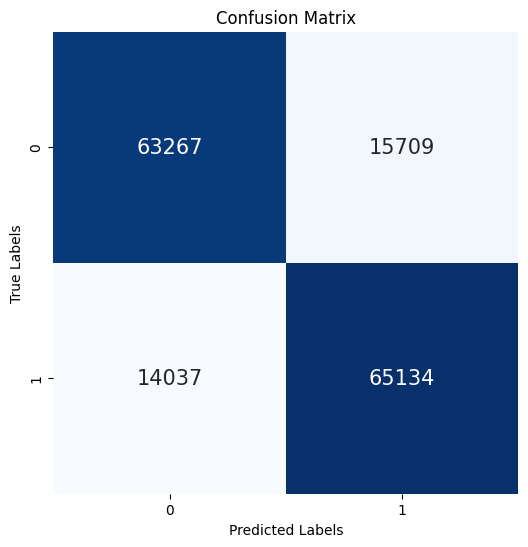

In [17]:
# Create a confusion matrix
cm = confusion_matrix(y_true, tf.argmax(y_pred.logits, 1))

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 15})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Evaluate the model
model.evaluate(test_dataset.batch(batch_size), verbose=2)

1236/1236 - 355s - loss: 0.4198 - accuracy: 0.8119 - 355s/epoch - 287ms/step


[0.41984686255455017, 0.8119091987609863]

# Model Testing

See the results

In [19]:
positive_tweets = [
    "Just had the best day ever! #FeelingBlessed 😊",
    "Celebrating success with my amazing team! 🎉 #TeamWork",
    "Enjoying a beautiful sunset at the beach. Life is good! 🌅 #Grateful",
    "This new song is my jam! 🎶 #MusicLover",
    "Excited for the weekend getaway with friends! 🚗 #WeekendVibes",
    "Achieved a major milestone today. Hard work pays off! 💪 #Success",
    "The support from my friends and family means everything to me. ❤️ #Love",
    "Positive vibes only! ✨ #Positivity",
    "Loving the positive energy around me. 😄 #GoodVibes",
    "Movie night with loved ones. Perfect way to relax! 🍿 #FamilyTime"
]

negative_tweets = [
    "Feeling so stressed out with work deadlines. 😓 #Stressed",
    "Everything seems to be going wrong today. 😞 #BadDay",
    "Dealing with a major setback. Can't catch a break. 😔 #Struggle",
    "This weather is ruining my plans. ☔ #WeatherWoes",
    "Stuck in traffic again. Just what I needed. 🚗 #TrafficJam",
    "Can't believe I lost my wallet. What a disaster! 😫 #LostAndFound",
    "Frustrated with technology. Nothing is working as it should. 🤬 #TechIssues",
    "Not feeling well today. 😷 #SickDay",
    "Relationship troubles are taking a toll on my mood. 💔 #Heartache",
    "Why does Monday have to come so quickly? 😩 #MondayBlues",
]

sample_texts = list(map(preprocess_text, positive_tweets)) + list(map(preprocess_text, negative_tweets))
sample_encodings = tokenizer.batch_encode_plus(sample_texts,
                                            padding=True,
                                            truncation=True,
                                            add_special_tokens=True,
                                            return_attention_mask=True,
                                            max_length=64,
                                            return_tensors='tf')
sample_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': list(sample_encodings['input_ids'].numpy()),
     'attention_mask': list(sample_encodings['attention_mask'].numpy())}
))
predictions = model.predict(sample_dataset.batch(batch_size))
print(predictions)

1/1 [==============================] - 3s 3s/step
TFSequenceClassifierOutput(loss=None, logits=array([[-1.5348996 ,  1.4784311 ],
       [-1.9414012 ,  1.8908291 ],
       [-2.31826   ,  2.784451  ],
       [-2.0238087 ,  2.4916437 ],
       [-1.8040324 ,  1.928266  ],
       [-1.5152403 ,  1.3708977 ],
       [-1.2647259 ,  1.6038808 ],
       [-1.2800016 ,  1.3966693 ],
       [-2.0965931 ,  2.463752  ],
       [-2.3158348 ,  2.7040393 ],
       [ 2.296519  , -2.3241549 ],
       [ 2.2705646 , -2.2707474 ],
       [ 2.350703  , -2.449372  ],
       [ 1.8302263 , -1.939936  ],
       [ 1.7076412 , -1.8339626 ],
       [ 2.470401  , -2.4413455 ],
       [ 2.2529993 , -2.3184493 ],
       [ 2.6031735 , -2.6323454 ],
       [ 2.6515682 , -2.6533809 ],
       [ 0.23527566, -0.3835272 ]], dtype=float32), hidden_states=None, attentions=None)


Display the predicted sentiments

In [20]:
sentiments = ['Negative', 'Positive']
for i in range(len(sample_texts)):
    pred_label = np.argmax(predictions.logits[i])
    print(f"Text: {sample_texts[i]}")
    print(f"Predicted Sentiment: {sentiments[pred_label]}")
    print()

Text: best day ever feelingbless 😊
Predicted Sentiment: Positive

Text: celebr success amaz team 🎉 teamwork
Predicted Sentiment: Positive

Text: enjoy beauti sunset beach life good 🌅 grate
Predicted Sentiment: Positive

Text: new song jam 🎶 musiclov
Predicted Sentiment: Positive

Text: excit weekend getaway friend 🚗 weekendvib
Predicted Sentiment: Positive

Text: achiev major mileston today hard work pay 💪 success
Predicted Sentiment: Positive

Text: support friend famili mean everyth ❤️ love
Predicted Sentiment: Positive

Text: posit vibe ✨ posit
Predicted Sentiment: Positive

Text: love posit energi around 😄 goodvib
Predicted Sentiment: Positive

Text: movi night love one perfect way relax 🍿 familytim
Predicted Sentiment: Positive

Text: feel stress work deadlin 😓 stress
Predicted Sentiment: Negative

Text: everyth seem go wrong today 😞 badday
Predicted Sentiment: Negative

Text: deal major setback cant catch break 😔 struggl
Predicted Sentiment: Negative

Text: weather ruin plan ☔ we